In [10]:
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import timm
from torch import nn
import numpy as np

DATA_DIR = 'train/'

# Loading DATA

In [11]:
df = pd.read_csv('train.csv')
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [41]:
class ReIdDataset(Dataset):
    
    def __init__(self,df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        Anchor = cv2.imread(DATA_DIR+self.df.iloc[idx].Anchor)
        Anchor = cv2.cvtColor(Anchor, cv2.COLOR_BGR2RGB)
        
        Negative = cv2.imread(DATA_DIR+self.df.iloc[idx].Negative)
        Negative = cv2.cvtColor(Negative, cv2.COLOR_BGR2RGB)
        
        Positive = cv2.imread(DATA_DIR+self.df.iloc[idx].Positive)
        Positive = cv2.cvtColor(Positive, cv2.COLOR_BGR2RGB)
        
        Anchor = torch.from_numpy(Anchor).permute(2,0,1)/255.0
        Negative = torch.from_numpy(Negative).permute(2,0,1)/255.0
        Positive = torch.from_numpy(Positive).permute(2,0,1)/255.0
        
        return Anchor, Positive, Negative

In [42]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)
trainset = ReIdDataset(train_df)
validset = ReIdDataset(valid_df)
print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 3200
Size of validset : 800


In [43]:
train = DataLoader(trainset, batch_size = 32,shuffle = False)
valid = DataLoader(validset, batch_size = 32)

In [44]:
print(f"No. of batches in trainloader : {len(train)}")
print(f"No. of batches in validloader : {len(valid)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


# Defining The Model

In [12]:
class CustomEfficientNet(nn.Module):
    
    def __init__(self, emb_size = 512):
        super(CustomEfficientNet, self).__init__()
        
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features,
                                                out_features = emb_size)
        
    
    def forward(self, images):
        features = self.efficientnet(images)
        return features

In [4]:
model = CustomEfficientNet()
model.to('cuda')

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Training
#### Developed a siamese network for person reidentification to match features

In [47]:
def get_train_loss(model, criterion, anchor, positive, negative):
    model.train()
    anchor = anchor.to('cuda')
    positive = positive.to('cuda')
    negative = negative.to('cuda')
    
    anchor_emb = model(anchor)
    positive_emb = model(positive)
    negative_emb = model(negative)
    
    loss = criterion(anchor_emb, positive_emb, negative_emb)
    
    return loss

In [48]:
def get_val_loss(model, valData, criterion):
    model.eval()
    loss = 0
    with torch.no_grad():
        for anchor, positive, negative in valData:
            anchor = anchor.to('cuda')
            positive = positive.to('cuda')
            negative = negative.to('cuda')

            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)
    
            loss += criterion(anchor_emb, positive_emb, negative_emb).item()
    
    return loss/len(valData)

### Triplet Loss Function

In [20]:
import torch.nn.functional as F

class TripletCosineLoss(nn.Module):
    def __init__(self, margin=0.4):
        super(TripletCosineLoss, self).__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        # Compute cosine similarities
        pos_similarity = F.cosine_similarity(anchor, positive)
        neg_similarity = F.cosine_similarity(anchor, negative)
        
        # Compute triplet loss
        loss = torch.relu(neg_similarity - pos_similarity + self.margin)
        
        return loss.mean()

criterion = TripletCosineLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

### Training Loop

In [50]:
epoch = 50
train_loss_all = []
val_loss_all = []
best_val_loss = np.Inf
for i in range(epoch):
    print("EPOCH ",i)
    with tqdm(train) as t:
        for anchor, positive, negative in t:
            
            train_loss = get_train_loss(model, criterion, anchor, positive, negative)
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            t.set_postfix({'train_loss':train_loss.item()})
            
        val_loss = get_val_loss(model, valid, criterion)
        
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), "model/best_model.pt")
            best_val_loss = val_loss
            print("SAVED_WEIGHT_SUCCESS")
        
    train_loss_all.append(train_loss.item())
    val_loss_all.append(val_loss)
    
    print("Train Loss : ", train_loss.item(), "   Val Loss : ", val_loss)
        

EPOCH  0


100%|██████████| 100/100 [00:27<00:00,  3.62it/s, train_loss=0.132]


SAVED_WEIGHT_SUCCESS
Train Loss :  0.13181889057159424    Val Loss :  0.07153372064232827
EPOCH  1


100%|██████████| 100/100 [00:22<00:00,  4.49it/s, train_loss=0.0313]


SAVED_WEIGHT_SUCCESS
Train Loss :  0.03130364790558815    Val Loss :  0.05783302888274193
EPOCH  2


100%|██████████| 100/100 [00:22<00:00,  4.43it/s, train_loss=0.0282] 


SAVED_WEIGHT_SUCCESS
Train Loss :  0.028205808252096176    Val Loss :  0.05370855074375868
EPOCH  3


100%|██████████| 100/100 [00:22<00:00,  4.53it/s, train_loss=0.0136] 


Train Loss :  0.013646451756358147    Val Loss :  0.06167329266667366
EPOCH  4


100%|██████████| 100/100 [00:21<00:00,  4.56it/s, train_loss=0.00723]


SAVED_WEIGHT_SUCCESS
Train Loss :  0.007229692302644253    Val Loss :  0.05351114109158516
EPOCH  5


100%|██████████| 100/100 [00:22<00:00,  4.52it/s, train_loss=0.0144] 


SAVED_WEIGHT_SUCCESS
Train Loss :  0.014378770254552364    Val Loss :  0.05120491251349449
EPOCH  6


100%|██████████| 100/100 [00:22<00:00,  4.53it/s, train_loss=0.0118] 


Train Loss :  0.011771287769079208    Val Loss :  0.05290520302951336
EPOCH  7


100%|██████████| 100/100 [00:22<00:00,  4.53it/s, train_loss=0.00682]


Train Loss :  0.006821362301707268    Val Loss :  0.05671873860061169
EPOCH  8


100%|██████████| 100/100 [00:21<00:00,  4.57it/s, train_loss=0.00473]


Train Loss :  0.0047310227528214455    Val Loss :  0.05407517954707146
EPOCH  9


100%|██████████| 100/100 [00:21<00:00,  4.56it/s, train_loss=0.0132] 


SAVED_WEIGHT_SUCCESS
Train Loss :  0.01316490862518549    Val Loss :  0.04757961109280586
EPOCH  10


100%|██████████| 100/100 [00:21<00:00,  4.55it/s, train_loss=0.00249]


Train Loss :  0.002494734711945057    Val Loss :  0.049578854478895665
EPOCH  11


100%|██████████| 100/100 [00:21<00:00,  4.57it/s, train_loss=0.00323]


SAVED_WEIGHT_SUCCESS
Train Loss :  0.0032342541962862015    Val Loss :  0.04447239991277456
EPOCH  12


100%|██████████| 100/100 [00:22<00:00,  4.53it/s, train_loss=0.00283]


Train Loss :  0.0028250152245163918    Val Loss :  0.056371494084596636
EPOCH  13


100%|██████████| 100/100 [00:22<00:00,  4.50it/s, train_loss=0.00951]


Train Loss :  0.00951321143656969    Val Loss :  0.05833448015153408
EPOCH  14


100%|██████████| 100/100 [00:21<00:00,  4.56it/s, train_loss=0.000388]


Train Loss :  0.00038760993629693985    Val Loss :  0.04615184407681227
EPOCH  15


100%|██████████| 100/100 [00:22<00:00,  4.51it/s, train_loss=0.00223]


SAVED_WEIGHT_SUCCESS
Train Loss :  0.002231569029390812    Val Loss :  0.03942418374121189
EPOCH  16


100%|██████████| 100/100 [00:21<00:00,  4.55it/s, train_loss=0.000871]


Train Loss :  0.0008705193176865578    Val Loss :  0.04460935596376658
EPOCH  17


100%|██████████| 100/100 [00:21<00:00,  4.56it/s, train_loss=0.00143]


Train Loss :  0.0014316672459244728    Val Loss :  0.04408129833638668
EPOCH  18


100%|██████████| 100/100 [00:21<00:00,  4.55it/s, train_loss=0.00822]


Train Loss :  0.008215918205678463    Val Loss :  0.040685454942286016
EPOCH  19


100%|██████████| 100/100 [00:21<00:00,  4.56it/s, train_loss=0.0081] 


Train Loss :  0.008097616024315357    Val Loss :  0.046532383933663365
EPOCH  20


100%|██████████| 100/100 [00:21<00:00,  4.56it/s, train_loss=0]      


Train Loss :  0.0    Val Loss :  0.04311945769935846
EPOCH  21


100%|██████████| 100/100 [00:21<00:00,  4.56it/s, train_loss=0.00255]


Train Loss :  0.0025498652830719948    Val Loss :  0.046667995750904086
EPOCH  22


100%|██████████| 100/100 [00:21<00:00,  4.55it/s, train_loss=0.00107]


Train Loss :  0.0010742107406258583    Val Loss :  0.045991442166268826
EPOCH  23


100%|██████████| 100/100 [00:21<00:00,  4.55it/s, train_loss=0]      


Train Loss :  0.0    Val Loss :  0.048719735704362395
EPOCH  24


100%|██████████| 100/100 [00:21<00:00,  4.55it/s, train_loss=0.00204]


Train Loss :  0.0020445892587304115    Val Loss :  0.04875468213111162
EPOCH  25


100%|██████████| 100/100 [00:22<00:00,  4.50it/s, train_loss=0.00227]


Train Loss :  0.002265200950205326    Val Loss :  0.046363657787442204
EPOCH  26


100%|██████████| 100/100 [00:22<00:00,  4.54it/s, train_loss=0.00153]


Train Loss :  0.0015263482928276062    Val Loss :  0.04663674678653479
EPOCH  27


100%|██████████| 100/100 [00:21<00:00,  4.56it/s, train_loss=0.00257]


Train Loss :  0.0025682514533400536    Val Loss :  0.04465573467314243
EPOCH  28


100%|██████████| 100/100 [00:22<00:00,  4.53it/s, train_loss=0.00865]


Train Loss :  0.008653568103909492    Val Loss :  0.043390224874019626
EPOCH  29


100%|██████████| 100/100 [00:22<00:00,  4.53it/s, train_loss=0.0041] 


Train Loss :  0.004096345044672489    Val Loss :  0.04225085724145174
EPOCH  30


100%|██████████| 100/100 [00:22<00:00,  4.53it/s, train_loss=0]      


Train Loss :  0.0    Val Loss :  0.041548158526420596
EPOCH  31


100%|██████████| 100/100 [00:22<00:00,  4.54it/s, train_loss=0.00246]


Train Loss :  0.002458875998854637    Val Loss :  0.043790423460304734
EPOCH  32


100%|██████████| 100/100 [00:22<00:00,  4.53it/s, train_loss=0]      


Train Loss :  0.0    Val Loss :  0.042275938279926775
EPOCH  33


100%|██████████| 100/100 [00:21<00:00,  4.55it/s, train_loss=0.00696]


Train Loss :  0.006963334046304226    Val Loss :  0.040789464451372624
EPOCH  34


100%|██████████| 100/100 [00:21<00:00,  4.55it/s, train_loss=0]      


Train Loss :  0.0    Val Loss :  0.04051449954509735
EPOCH  35


100%|██████████| 100/100 [00:21<00:00,  4.56it/s, train_loss=0.00103]


SAVED_WEIGHT_SUCCESS
Train Loss :  0.0010289466008543968    Val Loss :  0.037934768721461294
EPOCH  36


100%|██████████| 100/100 [00:22<00:00,  4.49it/s, train_loss=0.00677]


Train Loss :  0.00676686130464077    Val Loss :  0.044941364265978334
EPOCH  37


100%|██████████| 100/100 [00:22<00:00,  4.53it/s, train_loss=0]      


Train Loss :  0.0    Val Loss :  0.041846488043665885
EPOCH  38


100%|██████████| 100/100 [00:22<00:00,  4.54it/s, train_loss=0.0078] 


Train Loss :  0.007797252386808395    Val Loss :  0.04414308190345764
EPOCH  39


100%|██████████| 100/100 [00:21<00:00,  4.55it/s, train_loss=7.83e-5]


Train Loss :  7.825903594493866e-05    Val Loss :  0.043249202631413936
EPOCH  40


100%|██████████| 100/100 [00:22<00:00,  4.38it/s, train_loss=0]      


Train Loss :  0.0    Val Loss :  0.0419036104530096
EPOCH  41


100%|██████████| 100/100 [00:22<00:00,  4.52it/s, train_loss=0]      


Train Loss :  0.0    Val Loss :  0.03982939828187227
EPOCH  42


100%|██████████| 100/100 [00:22<00:00,  4.51it/s, train_loss=0.00561]


Train Loss :  0.005614208988845348    Val Loss :  0.041783446297049526
EPOCH  43


100%|██████████| 100/100 [00:21<00:00,  4.55it/s, train_loss=0]      


SAVED_WEIGHT_SUCCESS
Train Loss :  0.0    Val Loss :  0.03489935673773289
EPOCH  44


100%|██████████| 100/100 [00:22<00:00,  4.53it/s, train_loss=0]      


Train Loss :  0.0    Val Loss :  0.03795829493552447
EPOCH  45


100%|██████████| 100/100 [00:22<00:00,  4.52it/s, train_loss=0]      


Train Loss :  0.0    Val Loss :  0.04181418277323246
EPOCH  46


100%|██████████| 100/100 [00:22<00:00,  4.51it/s, train_loss=0.00921]


Train Loss :  0.00921462569385767    Val Loss :  0.0447344721481204
EPOCH  47


100%|██████████| 100/100 [00:21<00:00,  4.55it/s, train_loss=0]      


Train Loss :  0.0    Val Loss :  0.052834356725215914
EPOCH  48


100%|██████████| 100/100 [00:21<00:00,  4.55it/s, train_loss=0.00367]


Train Loss :  0.0036744968965649605    Val Loss :  0.0442708794400096
EPOCH  49


100%|██████████| 100/100 [00:21<00:00,  4.55it/s, train_loss=0.00459]


Train Loss :  0.004594278521835804    Val Loss :  0.04729499470442534


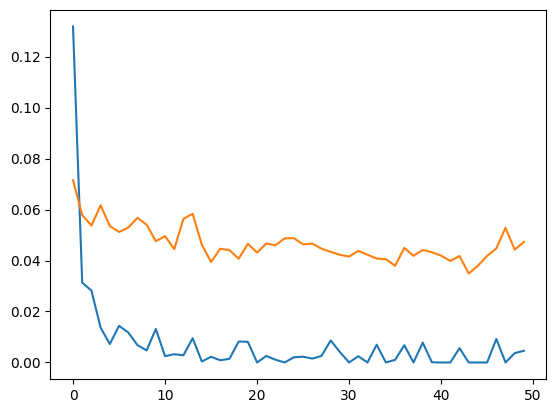

In [51]:
from matplotlib import pyplot as plt
plt.plot([i for i in range(len(train_loss_all))],train_loss_all)
plt.plot([i for i in range(len(val_loss_all))],val_loss_all)
plt.show()

#  INFERENCE

In [25]:
model.load_state_dict(torch.load("models/Eff.pt")) #These weights are same as the one saved before

<All keys matched successfully>

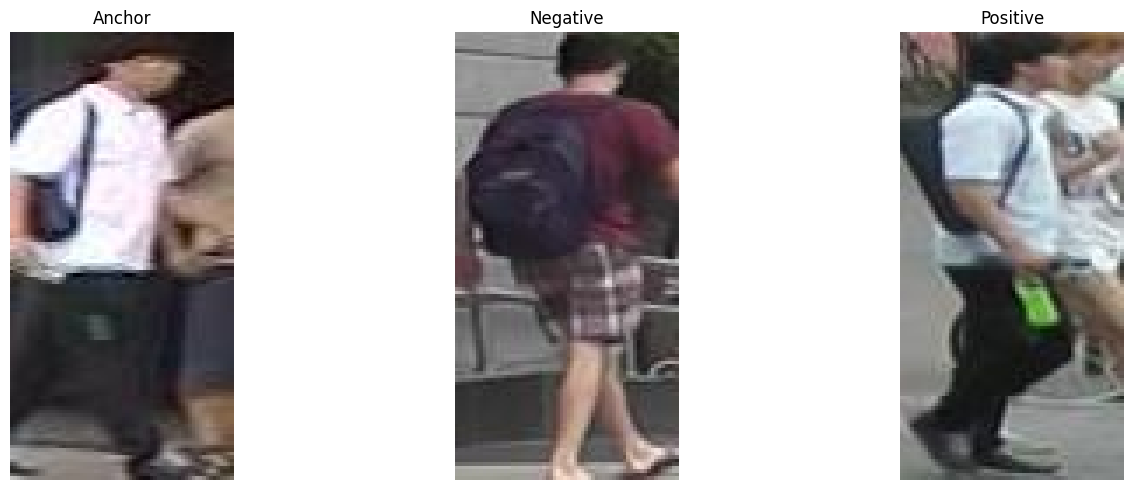

In [46]:
import matplotlib.pyplot as plt
idx = 52
Anchor = cv2.imread(DATA_DIR+df.iloc[idx].Anchor)
Negative = cv2.imread(DATA_DIR+df.iloc[idx].Negative)
Positive = cv2.imread(DATA_DIR+df.iloc[idx].Positive)
Anchor = cv2.cvtColor(Anchor, cv2.COLOR_BGR2RGB)
Negative = cv2.cvtColor(Negative, cv2.COLOR_BGR2RGB)
Positive = cv2.cvtColor(Positive, cv2.COLOR_BGR2RGB)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(Anchor)
axes[0].set_title('Anchor')
axes[0].axis('off')

axes[1].imshow(Negative)
axes[1].set_title('Negative')
axes[1].axis('off')

axes[2].imshow(Positive)
axes[2].set_title('Positive')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [47]:
model.eval()
with torch.no_grad():
    Anchor = torch.from_numpy(Anchor).permute(2,0,1)/255.0
    Negative = torch.from_numpy(Negative).permute(2,0,1)/255.0
    Positive = torch.from_numpy(Positive).permute(2,0,1)/255.0

    Anchor = Anchor.to('cuda')
    Negative = Negative.to('cuda')
    Positive = Positive.to('cuda')

    batch = torch.stack([Anchor, Negative, Positive], dim=0)
    Anchor_emb, Negative_emb, Positive_emb = model(batch)
    
print('Similarity b/w Anchor and Negative Sample - ',F.cosine_similarity(Anchor_emb.unsqueeze(0), 
                                                                         Negative_emb.unsqueeze(0)).item())
print('Similarity b/w Anchor and Positive Sample - ',F.cosine_similarity(Anchor_emb.unsqueeze(0), 
                                                                         Positive_emb.unsqueeze(0)).item())

torch.Size([1, 512])
Similarity b/w Anchor and Negative Sample -  -0.19219431281089783
Similarity b/w Anchor and Positive Sample -  0.7878501415252686
